### Clément Barras
# Deep Learning : Mini-Project 1


### Preliminary step
We first import the necessary functions :

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape, Flatten, Dropout, UpSampling2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils
from keras.optimizers import SGD, Adam


# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


#im = generate_a_rectangle(10, True)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#im = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

Using TensorFlow backend.


### 1) Simple classification

First, we generate the training and testing data :

In [29]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
#X_train = (X_train - np.mean(X_train))/np.std(X_train)
Y_train = np_utils.to_categorical(Y_train)

X_test = generate_a_disk()/255
X_test = X_test.reshape(1, X_test.shape[0])

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


The model is a single layer linear model with a sigmoid activation function (so is not linear *stricto sensu*)

First, with the SGD optimizer :

In [25]:
model = Sequential([
    Dense(3, input_shape=(5184,), activation= "sigmoid")
    ])

sgd = SGD(lr=0.003, decay=1e-5, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=["acc"])
model.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
500/500 [==============================] - 0s 719us/step - loss: 0.5910 - acc: 0.7100
Epoch 2/20
500/500 [==============================] - 0s 163us/step - loss: 0.3876 - acc: 0.8560
Epoch 3/20
500/500 [==============================] - 0s 156us/step - loss: 0.3042 - acc: 0.9053
Epoch 4/20
500/500 [==============================] - 0s 153us/step - loss: 0.2585 - acc: 0.9227
Epoch 5/20
500/500 [==============================] - 0s 164us/step - loss: 0.2253 - acc: 0.9433
Epoch 6/20
500/500 [==============================] - 0s 152us/step - loss: 0.2033 - acc: 0.9500
Epoch 7/20
500/500 [==============================] - 0s 156us/step - loss: 0.1810 - acc: 0.9633
Epoch 8/20
500/500 [==============================] - 0s 155us/step - loss: 0.1670 - acc: 0.9653
Epoch 9/20
500/500 [==============================] - 0s 156us/step - loss: 0.1563 - acc: 0.9727
Epoch 10/20
500/500 [==============================] - 0s 168us/step - loss: 0.1482 - acc: 0.9673
Epoch 11/20
500/500 [========

Then, with Adam :

In [30]:
model = Sequential([
    Dense(3, input_shape=(5184,), activation= "sigmoid")
    ])

adam = Adam(lr=0.001, decay=1e-6)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=["acc"])
model.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 0s 1ms/step - loss: 0.7649 - acc: 0.5689
Epoch 2/20
300/300 [==============================] - 0s 167us/step - loss: 0.4648 - acc: 0.7789
Epoch 3/20
300/300 [==============================] - 0s 147us/step - loss: 0.3599 - acc: 0.8278
Epoch 4/20
300/300 [==============================] - 0s 180us/step - loss: 0.2921 - acc: 0.9044
Epoch 5/20
300/300 [==============================] - 0s 188us/step - loss: 0.2599 - acc: 0.9067
Epoch 6/20
300/300 [==============================] - 0s 162us/step - loss: 0.2290 - acc: 0.9500
Epoch 7/20
300/300 [==============================] - 0s 150us/step - loss: 0.2185 - acc: 0.9322
Epoch 8/20
300/300 [==============================] - 0s 147us/step - loss: 0.1949 - acc: 0.9522
Epoch 9/20
300/300 [==============================] - 0s 160us/step - loss: 0.1982 - acc: 0.9344
Epoch 10/20
300/300 [==============================] - 0s 173us/step - loss: 0.2225 - acc: 0.8922
Epoch 11/20
300/300 [==========

The convergence to perfect accuracy *on the training set* is almost ensured with Adam, but performances are slightly worse with SGD.

Predicted class probabilites :
Rectangle : 0.038
Disque : 0.987
Triangle : 0.000


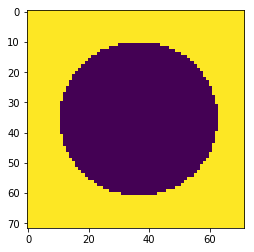

In [27]:
img = np.reshape(X_test, (72, 72))
plt.imshow(img)

categories = ["Rectangle", "Disque", "Triangle"]
predictions = model.predict(X_test).T
print("Predicted class probabilites :")
for i in range(3):
    print("{} : {:.3f}".format(categories[i], predictions[i][0]))

Then, we display the weights :

In [32]:
weights = model.get_weights()[0]
fig, ax = plt.subplots(1, 3, figsize = (30, 10))

for i in range(3):
    img = np.reshape(weights[:,i], (72, 72))**2
    ax[i].imshow(img)

### 3) A More Difficult Classification Problem

First, we generate training and testing data. I increased the number of training samples to limit overfitting.

In [14]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
Y_train = np_utils.to_categorical(Y_train)
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


#### a) Linear model

In this part, we use the previous linear model :

In [17]:
model = Sequential([
    Dense(3, input_shape=(5184,), activation= "sigmoid")
    ])

adam = Adam(lr=0.001, decay=1e-6)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=["acc"])
model.fit(X_train, Y_train, epochs=25, batch_size=32, verbose = 1)

Epoch 1/25
1000/1000 [==============================] - 0s 372us/step - loss: 0.7546 - acc: 0.6100
Epoch 2/25
1000/1000 [==============================] - 0s 144us/step - loss: 0.5852 - acc: 0.6970
Epoch 3/25
1000/1000 [==============================] - 0s 160us/step - loss: 0.5799 - acc: 0.7023
Epoch 4/25
1000/1000 [==============================] - 0s 156us/step - loss: 0.5263 - acc: 0.7310
Epoch 5/25
1000/1000 [==============================] - 0s 160us/step - loss: 0.5234 - acc: 0.7387
Epoch 6/25
1000/1000 [==============================] - 0s 160us/step - loss: 0.4995 - acc: 0.7500
Epoch 7/25
1000/1000 [==============================] - 0s 156us/step - loss: 0.4817 - acc: 0.7520
Epoch 8/25
1000/1000 [==============================] - 0s 172us/step - loss: 0.4799 - acc: 0.7600
Epoch 9/25
1000/1000 [==============================] - 0s 168us/step - loss: 0.4747 - acc: 0.7593
Epoch 10/25
1000/1000 [==============================] - 0s 160us/step - loss: 0.5046 - acc: 0.7513
Epoch 11/

In [18]:
los, acc = model.evaluate(X_test, Y_test)
print("Testing average binary crossentropy = {:.3f}".format(los))
print("Testing prediction accuracy = {:.3f}".format(acc))

300/300 [==============================] - 0s 320us/step
Testing average binary crossentropy = 0.570
Testing prediction accuracy = 0.739


#### b) Convolutional model

Convolutional layers accept input of shape *(batch_size, width, height, n_channels)* : we first need to reshape the data.

In [19]:
def to_cnn_input(Z, w = 72, h = 72):
    if len(Z.shape) != 4:
        return np.reshape(Z, (-1, w, h, 1))
    else:
        return Z
X_train = to_cnn_input(X_train)
X_test = to_cnn_input(X_test)

In [62]:
model_cnn = Sequential([
    Conv2D(16, (5, 5), activation = "relu", padding = "same"),
    Dropout(0.1),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(3, activation= "sigmoid"),
    ])

sgd = SGD(lr=0.001, decay=1e-5, momentum=0.9, nesterov=True)
adam = Adam(lr = 0.001, decay = 1e-5)
model_cnn.compile(loss='binary_crossentropy',optimizer=adam, metrics=["acc"])
model_cnn.fit(X_train, Y_train, epochs=25, batch_size=16, verbose = 1)

Epoch 1/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5752 - acc: 0.7000
Epoch 2/25
1000/1000 [==============================] - 1s 568us/step - loss: 0.4319 - acc: 0.7997
Epoch 3/25
1000/1000 [==============================] - 1s 568us/step - loss: 0.3694 - acc: 0.8410
Epoch 4/25
1000/1000 [==============================] - 1s 568us/step - loss: 0.3227 - acc: 0.8707
Epoch 5/25
1000/1000 [==============================] - 1s 568us/step - loss: 0.2843 - acc: 0.8943
Epoch 6/25
1000/1000 [==============================] - 1s 592us/step - loss: 0.2519 - acc: 0.9143
Epoch 7/25
1000/1000 [==============================] - 1s 564us/step - loss: 0.2252 - acc: 0.9280
Epoch 8/25
1000/1000 [==============================] - 1s 576us/step - loss: 0.1947 - acc: 0.9347
Epoch 9/25
1000/1000 [==============================] - 1s 576us/step - loss: 0.1670 - acc: 0.9527
Epoch 10/25
1000/1000 [==============================] - 1s 604us/step - loss: 0.1579 - acc: 0.9647
Epoch 11/25

In [63]:
los, acc = model_cnn.evaluate(X_test, Y_test)
print("Testing average binary crossentropy = {:.3f}".format(los))
print("Testing prediction accuracy = {:.3f}".format(acc))

300/300 [==============================] - 0s 1ms/step
Testing average binary crossentropy = 0.210
Testing prediction accuracy = 0.929


This model performs much better than the previous one. By default, the classification accuracy was of 88%, but we gained 5% by reducing overfitting by :
- Decreasing the number of epoch
- Decreazing the batch size
- Introducing a dropout layer

### 4) A Regression Problem

For preprocessing the data, we chose to order the output data vertices in increasing angles (considering the middle of the image as the center). By doing so, we increase the consistency of the data to predict.

In [239]:
def reorder_vertices(Y):
    def calc_angle(x,y):
        return np.arctan(y/x)
    for i in range(Y.shape[0]):
        z = Y[i]
        angles = [calc_angle(z[2*j], z[2*j+1]) for j in range(3)]
        asort = np.argsort(angles)
        order = []
        for k in range(3):
            order.append(2*asort[k])
            order.append(2*asort[k]+1)
        Y[i, :] = Y[i, order]
    return Y

In [ ]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)
[X_test, Y_test] = generate_test_set_regression()

The model is a convolutive model with 4 convolution layersand one dense layers. Dropout layers were added to limit overfitting.

In [236]:
X_train_2D = to_cnn_input(X_train)
X_test_2D = to_cnn_input(X_test)
Y_train = reorder_vertices(Y_train)
Y_test = reorder_vertices(Y_test)

model = Sequential([
    Conv2D(10, (3, 3), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    #Dropout(0.2),
    Conv2D(20, (3, 3), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    #Dropout(0.2),
    Conv2D(20, (3, 3), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    Dropout(0.3),
    Conv2D(20, (3, 3), activation = "relu", padding = "same"),
    Dropout(0.3),
    Flatten(),
    Dense(6),
    ])

adam = Adam(lr=0.003, decay=1e-3)
model.compile(loss='mean_squared_error',optimizer=adam)
model.fit(X_train_2D, Y_train, epochs=100, batch_size=64)

Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1282
Epoch 2/100
1000/1000 [==============================] - 0s 294us/step - loss: 0.0667
Epoch 3/100
1000/1000 [==============================] - 0s 283us/step - loss: 0.0592
Epoch 4/100
1000/1000 [==============================] - 0s 279us/step - loss: 0.0458
Epoch 5/100
1000/1000 [==============================] - 0s 281us/step - loss: 0.0403
Epoch 6/100
1000/1000 [==============================] - 0s 298us/step - loss: 0.0366
Epoch 7/100
1000/1000 [==============================] - 0s 282us/step - loss: 0.0332
Epoch 8/100
1000/1000 [==============================] - 0s 283us/step - loss: 0.0311
Epoch 9/100
1000/1000 [==============================] - 0s 287us/step - loss: 0.0293
Epoch 10/100
1000/1000 [==============================] - 0s 283us/step - loss: 0.0278
Epoch 11/100
1000/1000 [==============================] - 0s 294us/step - loss: 0.0266
Epoch 12/100
1000/1000 [==============================

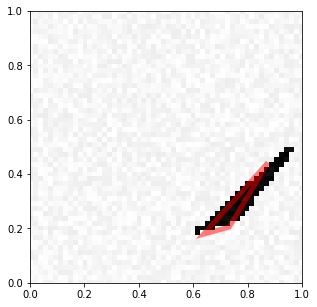

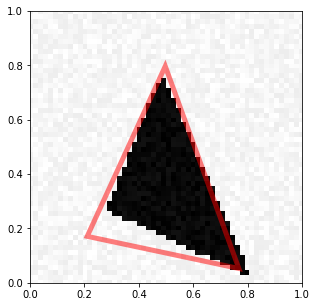

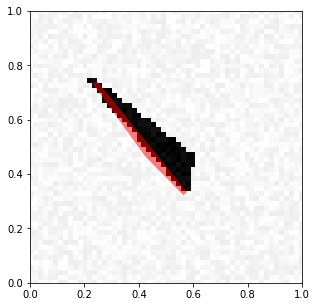

1000/1000 [==============================] - 1s 1ms/step
Training mse = 5.2734e-03


In [237]:
Y_predict = model.predict(X_train_2D)

for i in np.random.randint(0, 300, 3):
    visualize_prediction(X_train[i], Y_predict[i])
    
los = model.evaluate(X_train_2D, Y_train)
print("Training mse = {:.4e}".format(los))

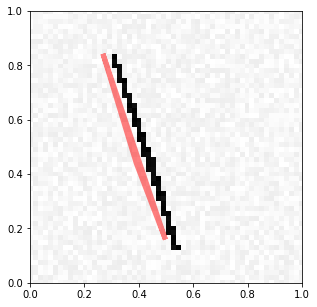

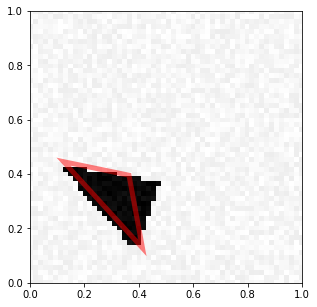

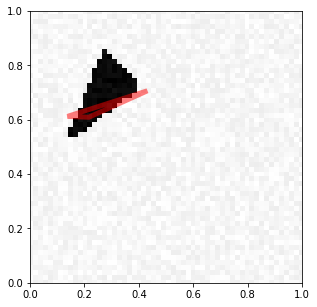

300/300 [==============================] - 0s 283us/step
Testing mse = 1.1447e-02


In [238]:
Y_predict = model.predict(X_test_2D)

for i in np.random.randint(0, 300, 3):
    visualize_prediction(X_test[i], Y_predict[i])
    
los = model.evaluate(X_test_2D, Y_test)
print("Testing mse = {:.4e}".format(los))

### 5) Image Denoising

We rewrite the code to add noise to the data.

In [176]:
def generate_a_rectangle_2(noise=1.0, free_location=True):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)

def generate_dataset_denoising(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = 72*72
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_rectangle_2(noise, True)
    Y =  Y / 255 
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

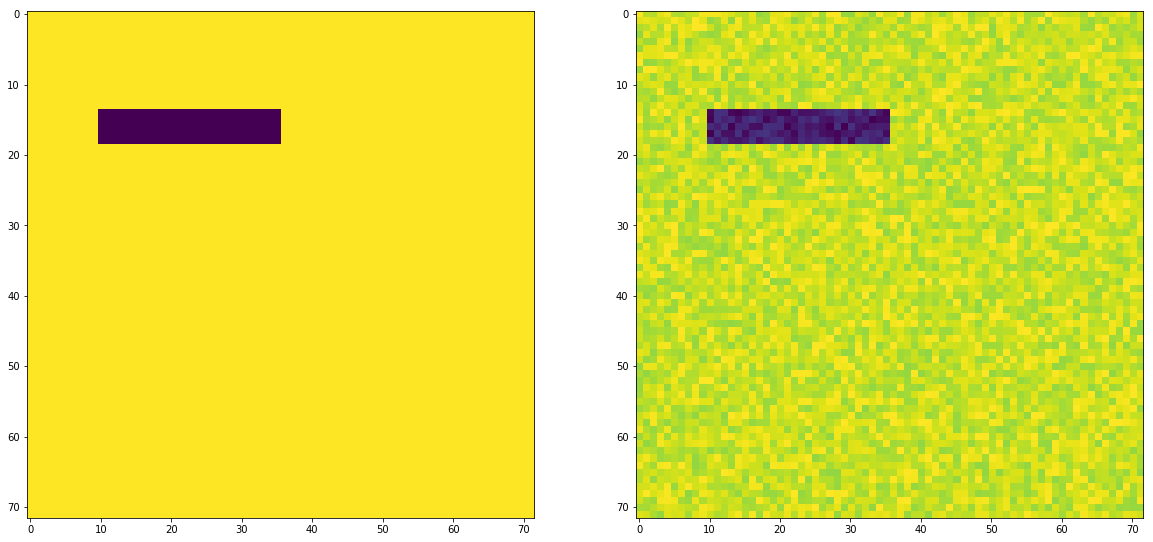

In [170]:
fig_clean, fig_noise = generate_a_rectangle_2(noise=50.0, free_location=True)

fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(np.reshape(fig_clean, (72, 72)))
ax[1].imshow(np.reshape(fig_noise, (72, 72)))

In [177]:
X_train, Y_train = generate_dataset_denoising(300, noise=50)
X_test, Y_test = generate_dataset_denoising(300, noise=50)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We use a hourglass model with 3 layers of pooling.

In [267]:
model = Sequential([
    Reshape((72, 72, 1)),
    Conv2D(20, (3, 3), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    Conv2D(40, (3, 3), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    Conv2D(80, (3, 3), activation = "relu", padding = "same"),
    MaxPool2D((2,2)),
    UpSampling2D((2,2)),
    Conv2DTranspose(80, (3, 3), activation = "relu", padding = "same"),
    UpSampling2D((2,2)),
    Conv2DTranspose(40, (3, 3), activation = "relu", padding = "same"),
    UpSampling2D((2,2)),
    Conv2DTranspose(20, (3, 3), activation = "relu", padding = "same"),
    Conv2DTranspose(10, (3, 3), activation = "relu", padding = "same"),
    Conv2DTranspose(1, (5, 5), activation = "relu", padding = "same"),
    Reshape((72*72,))
    ])


adam = Adam(lr=0.001, decay=1e-3)
model.compile(loss='mean_squared_error',optimizer=adam) 
model.fit(X_train, Y_train, epochs=500, batch_size=16)

Epoch 1/500
300/300 [==============================] - 7s 24ms/step - loss: 0.3322
Epoch 2/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0576
Epoch 3/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0268
Epoch 4/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0175
Epoch 5/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0141
Epoch 6/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0113
Epoch 7/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0096
Epoch 8/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0082
Epoch 9/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 10/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0060
Epoch 11/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 12/500
300/300 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 13/500

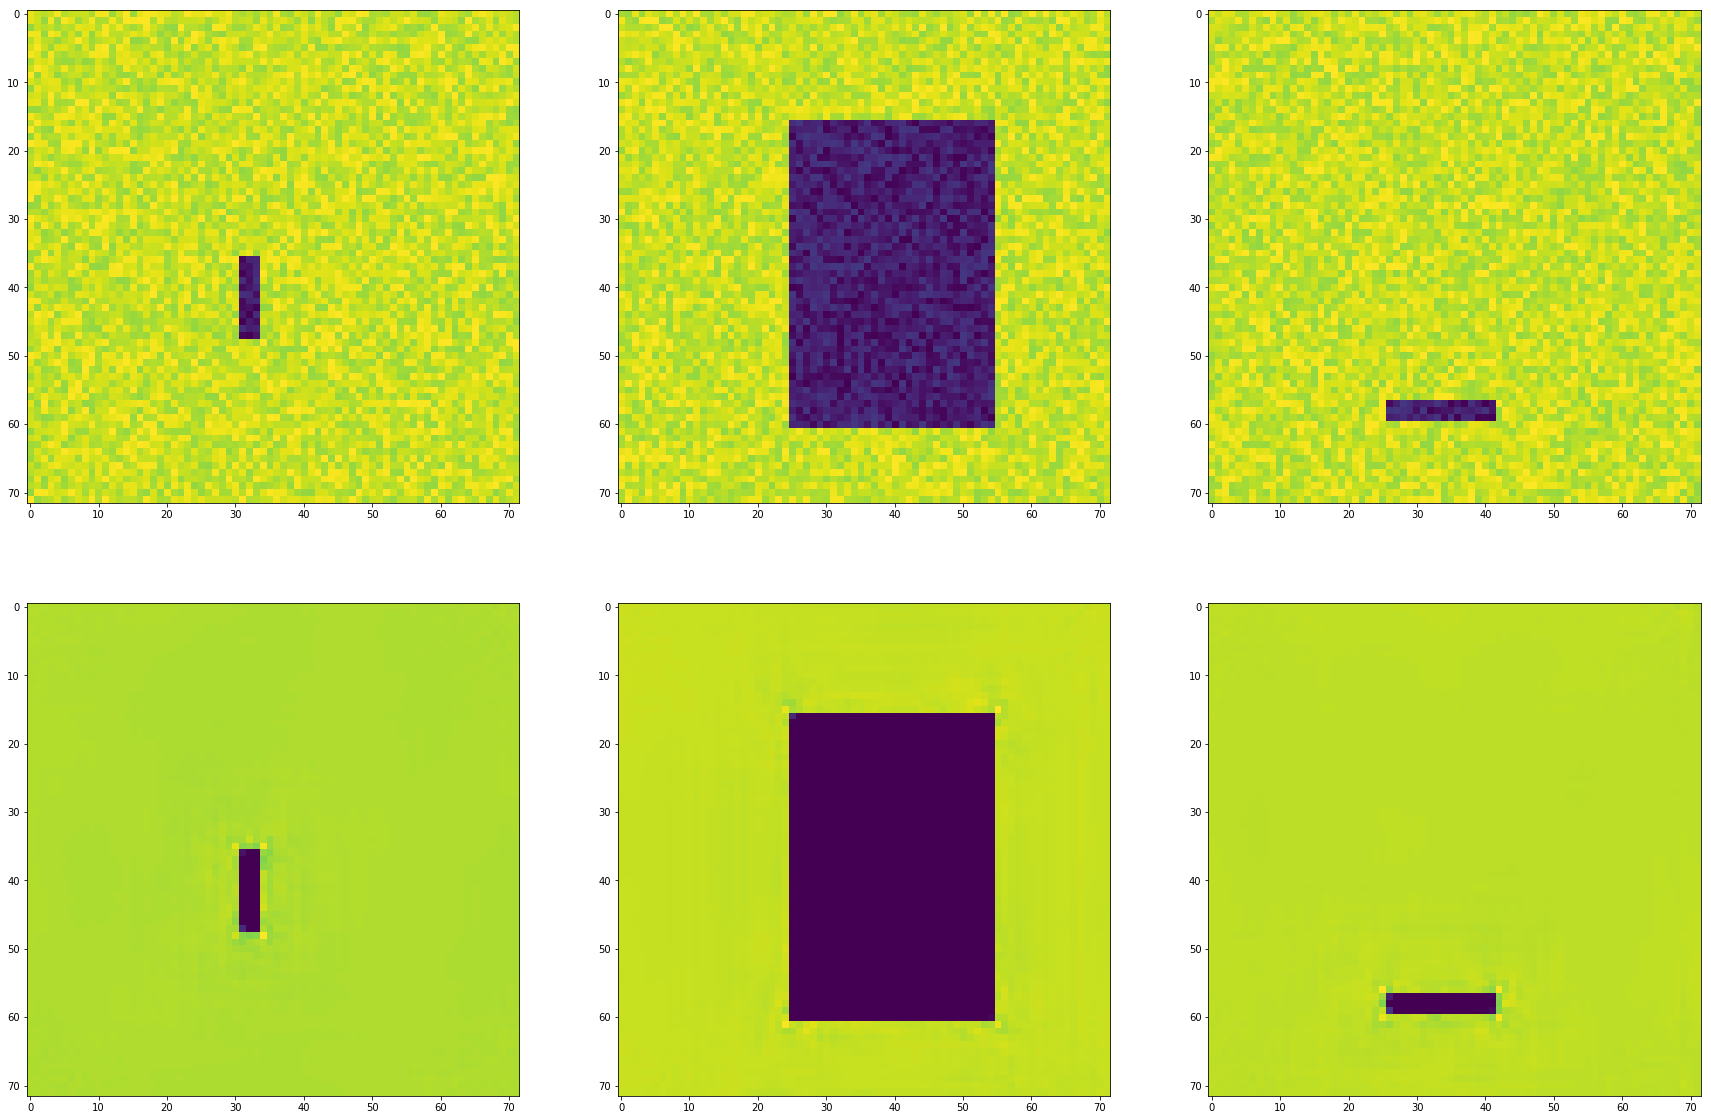

In [268]:
fig, ax = plt.subplots(2, 3, figsize = (30, 20))

for i in range(3):
    ax[0][i].imshow(np.reshape(X_train[i], (72, 72)))
    ax[1][i].imshow(np.reshape(model.predict(X_train[i][None]), (72, 72)))